# hip2tex
ヒッパルコス星表のデータをいい感じに処理して、Shaderで表示するためのテクスチャに変換したい。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import struct

In [2]:
hip = pd.read_table("BrowseTargets.13041.1545121565", sep="|", header=2, usecols=range(1, 7), skipinitialspace=True)
hip.head()

,name,parallax,vmag,ra_deg,dec_deg,bv_color
0,HIP 48752,4.17,7.84,149.167261,-89.782454,0.097
1,HIP 71348,2.08,6.82,218.878316,-89.771696,1.698
2,HIP 42708,2.39,7.20,130.518546,-89.460502,1.712
3,HIP 78866,11.95,7.83,241.481011,-89.308449,0.412
4,HIP 22645,4.42,8.86,73.084128,-89.273961,0.260


# 欠損値処理
各項目の欠損値の数

In [3]:
hip.isnull().sum()

name           0
parallax     263
vmag           1
ra_deg       263
dec_deg      263
bv_color    1281
dtype: int64

Parallaxが0以下の星は除外する。

In [4]:
hip = hip[(hip["parallax"] > 0)]

bv_colorはなんか適当に埋めてみる。  
とりあえず中央値で埋める。

In [5]:
hip["bv_color"] = hip["bv_color"].fillna(hip["bv_color"].median())

欠けたデータを除外した後の星の数

In [6]:
len(hip)

113710

# 座標変換
年周視差([parallax](https://heasarc.gsfc.nasa.gov/W3Browse/star-catalog/hipparcos.html#parallax)) $pi$と距離(parsec) $D$の関係は$D = 1000 / pi$。1 parsecは3.26光年。  
球座標系を直交座標系に変換する式はこんな感じになるはず。

$$
\begin{eqnarray}
x &=& \dfrac {1000}{P_{parallax}}\cos \theta_{dec} \cos \phi_{ra} \\
y &=& \dfrac {1000}{P_{parallax}}\cos \theta_{dec} \sin \phi_{ra} \\
z &=& \dfrac {1000}{P_{parallax}}\sin \theta_{dec}
\end{eqnarray}
$$

In [7]:
pos = np.empty((0, 3), dtype = "float32")

for index, i in hip.iterrows():
    x = 1000 / i["parallax"] * np.cos(np.deg2rad(i["dec_deg"])) * np.cos(np.deg2rad(i["ra_deg"]))
    y = 1000 / i["parallax"] * np.cos(np.deg2rad(i["dec_deg"])) * np.sin(np.deg2rad(i["ra_deg"]))
    z = 1000 / i["parallax"] * np.sin(np.deg2rad(i["dec_deg"]))
    pos = np.append(pos, np.array([[x, y, z]], dtype = "float32"), axis=0)

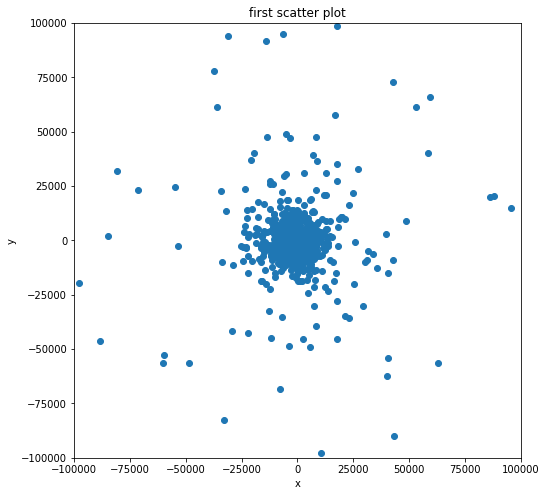

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-100000,100000)
ax.set_ylim(-100000,100000)

ax.scatter(pos[0:,0], pos[0:,1])

ax.set_title('first scatter plot')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [9]:
r = np.empty((2, 0, 3))
c = np.empty((0, 2048, 3))

count = 0

for p in pos:
    a = np.empty((2, 2, 0))
    
    for xyz in p:
        xs = struct.pack('>f', xyz)
        xn = struct.unpack('>L', xs)[0]
        b = np.array([[[xn >> 0 & 0xff],[xn >> 8 & 0xff]],
                      [[xn >> 16 & 0xff],[xn >> 24 & 0xff]]])
        a = np.append(a, b, axis=2)
    
    r = np.append(r, a, axis=1)
    count+=1
    
    if count > 1023:
        c = np.append(c, r, axis=0)
        r = np.empty((2, 0, 3))
        count = 0

r = np.pad(r, ((0,0),(0,2048 - r.shape[1]),(0,0)), "constant")
c = np.append(c, r, axis=0) 

In [10]:
pos_tex = np.pad(c, ((0,2048 - c.shape[0]),(0,0),(0,0)), "constant")
pos_tex = Image.fromarray(np.uint8(np.round(pos_tex)))
pos_tex.save("texture/pos_tex.png")

# 絶対等級
[絶対等級](https://bit.ly/2A1RmtT)$M$は視等級$m$と年周視差$\pi$(秒)から計算できる。

$$
M=m-5\left( \log _{10} \pi +1\right)
$$

In [11]:
abs_mag = np.empty((0, 1))

for index, i in hip.iterrows():
    M = i["vmag"] - 5 * (np.log10(i["parallax"]) / 1000 + 1)
    abs_mag = np.append(abs_mag, np.array([[M]]), axis=0)

In [12]:
abs_mag_tex = (abs_mag - abs_mag.min()) / (abs_mag.max() - abs_mag.min()) * 255
abs_mag_tex = np.pad(abs_mag_tex, ((0,1024 ** 2 - len(abs_mag_tex)),(0,0)), "constant")
abs_mag_tex = np.reshape(abs_mag_tex, (1024, 1024))
abs_mag_tex = Image.fromarray(np.uint8(np.round(abs_mag_tex)))
abs_mag_tex.save("texture/abs_mag_tex.png")

# 星の描画サイズ計算
視等級$m$が1減るごとに面積が2.512倍され、年周視差に直径が反比例するように計算してみる。

$$
R = \dfrac {\sqrt{2.512^{-m}}}{P_{parallax}}
$$

In [13]:
v_mag = np.empty((0, 1))

for index, i in hip.iterrows():
    R = np.sqrt(2.512 ** (- i["vmag"])) / i["parallax"]
    v_mag = np.append(v_mag, np.array([[R]]), axis=0)

In [14]:
v_mag_uint24 = (v_mag - v_mag.min()) / (v_mag.max() - v_mag.min()) * 16777215
v_mag_uint24 = v_mag_uint24.astype(np.uint32)

v_mag_pack = np.empty((0, 3))

for i in v_mag_uint24:
    pack = np.array([[i[0] >> 16 & 0xff, i[0] >> 8 & 0xff, i[0] >> 0 & 0xff]])
    v_mag_pack = np.append(v_mag_pack, pack, axis=0)

v_mag_tex = np.pad(v_mag_pack, ((0,1024 ** 2 - len(v_mag_pack)),(0,0)), "constant")
v_mag_tex = np.reshape(v_mag_tex, (1024, 1024, 3))
v_mag_tex = Image.fromarray(np.uint8(np.round(v_mag_tex)))
v_mag_tex.save("texture/v_mag_tex.png")

# 星の色
bv_colorからRGBに変換する。  
[Star B-V color index to apparent RGB color - stackoverflow](https://stackoverflow.com/questions/21977786/star-b-v-color-index-to-apparent-rgb-color)でまとめられている数式を使ってみる。

In [15]:
color = np.empty((0, 3))

A = np.array([[3.2406, -1.5372, -0.4986],
              [-0.9689, 1.8758, 0.0415],
              [0.0557, -0.204, 1.057]])

for index, i in hip.iterrows():
    # B-V to Kelvin
    t = 4600 * (1 / (0.92 * i["bv_color"] + 1.7) + 1 / (0.92 * i["bv_color"] + 0.62))
    
    # Kelvin to xyY
    if t <= 4000:
        x = ((-0.2661239 * pow(10,9)) / pow(t,3)) + ((-0.2343580 * pow(10,6)) / pow(t,2)) + ((0.8776956 * pow(10,3)) / t) + 0.179910
        
    else:
        x = ((-3.0258469 * pow(10,9)) / pow(t,3)) + ((2.1070379 * pow(10,6)) / pow(t,2)) + ((0.2226347 * pow(10,3)) / t) + 0.240390
        
    if t <= 2222:
        y = -1.1063814 * pow(x,3) - 1.34811020 * pow(x,2) + 2.18555832 * x - 0.20219683
        
    elif t <= 4000:
        y = -0.9549476 * pow(x,3) - 1.37418593 * pow(x,2) + 2.09137015 * x - 0.16748867
        
    else:
        y = 3.0817580 * pow(x,3) - 5.87338670 * pow(x,2) + 3.75112997 * x - 0.37001483
        
    # xyY to XYZ
    if y == 0:
        Y = 0
        X = 0
        Z = 0
    else:
        Y = 1
        X = (x * Y) / y
        Z = (1 - x - y) * Y / y
        
    XYZ = np.array([[X],
                    [Y],
                    [Z]])
    
    # XYZ to RGB
    rgb = A.dot(XYZ).T
    
    # RGB to sRGB
    for c in range(3):
        if rgb[0][c] <= 0.0031308:
            rgb[0][c] = 12.92 * rgb[0][c]
        else:
            rgb[0][c] = 1.055 * pow(rgb[0][c], 2) - 0.055

    color = np.append(color, rgb, axis=0)
    
color = np.clip(color * 255, 0, 255)

In [16]:
color_tex = np.pad(color, ((0,1024 ** 2 - len(color)),(0,0)), "constant")
color_tex = np.reshape(color_tex, (1024, 1024, 3))
color_tex = Image.fromarray(np.uint8(np.round(color_tex)))
color_tex.save("texture/color_tex.png")

# メモ
検算用

In [17]:
pos_tex = Image.open("texture/pos_tex.png")
pos_tex = np.asarray(pos_tex)

In [18]:
u = 0 * 2
v = 0 * 2
v1 = np.array(pos_tex[u][v], dtype = "int") << 0
v1 += np.array(pos_tex[u][v+1], dtype = "int") << 8
v1 += np.array(pos_tex[u+1][v], dtype = "int") << 16
v1 += np.array(pos_tex[u+1][v+1], dtype = "int") << 24

In [19]:
print(hex(v1[0]))
print(hex(v1[1]))
print(hex(v1[2]))

0xbf482682
0x3eeeeff4
0xc36fce72


In [20]:
pos[0]

array([  -0.7818376 ,    0.46667445, -239.80643   ], dtype=float32)